# INPUT PATTERNS GENERATION

In [1]:
''' Generates and saves parameters required for generating MF input patterns
    with specified firing rates and correlations using Dichotomized Gaussian
    model from Macke et al. 2009 (DOI: 10.1162/neco.2008.02-08-713) '''

' Generates and saves parameters required for generating MF input patterns\n    with specified firing rates and correlations using Dichotomized Gaussian\n    model from Macke et al. 2009 (DOI: 10.1162/neco.2008.02-08-713) '

In [2]:
# Importing libraries
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
from numpy.linalg import LinAlgError
from scipy.stats import norm
import random
import math
import os
import warnings
import sys

In [3]:
################# PARAMETERS ###########################
######## 01_anatomical_model_generation ################

seed = 0 ## seed for the positions generation
total_size = 100.0 # side size of the cube in um

######## 02_input_patterns_generation ##################

## Parameter to set the spatial correlation between MFs 
## (The larger, the more correlation)
## List of sigmas 
sigmas = [5] 

## List of MF active fractions that will be used 
## (from 5% to 95% of pattern activity )
f_mf = np.linspace(.05, 0.95, 10)

## Number of patterns to be generated for each pair
## of sigma and MF active fraction 
num_patterns = 640

########################################################

### Functions used as reference to generate the inputs


In [4]:
''' To check the reference code go to pop_spike repo from Macke Lab
    see https://bitbucket.org/mackelab/pop_spike/src '''

' To check the reference code go to pop_spike repo from Macke Lab\n    see https://bitbucket.org/mackelab/pop_spike/src '

In [5]:

def heaviside(_input, center=0):
    """Implements sgn(_input - center)."""
    spikes = np.zeros_like(_input)
    spikes[_input > center] = 1.
    return spikes


def cov_to_corr(cov):
    """Converts input covariance matrix into correlation matrix."""
    std = np.sqrt(np.diag(cov))
    std_mat = np.outer(std, std)
    return cov / (std_mat + 1e-8)


def make_symmetric(M):
    """Makes input matrix symmetric, if it is non-symmetric."""
    M_copy = M
    if np.any(M != M.T):
        print('made symmetric')
        tril_inds = np.tril_indices(len(M), -1)
        M_copy[tril_inds] = M[tril_inds[1], tril_inds[0]].flatten()
    return M_copy


In [6]:

class Higham:
    """ Converts an input symmetric matrix M into a positive semi-definite matrix A using the Higham iterative
        projection algorithm to minimize the Frobenius norm between A and M.
        Reference: NJ Higham, Computing the nearest correlation matrix - a problem from finance, IMA Journal of
        Numerical Analysis, 2002import numpy as np
        Inputs:
        maxiters: max. number of iterations for iterative projection algorithm. Default is 100,000.
        tol: tolerance value for Frobenius norm. Default is 1e-10.
    """

    def __init__(self, maxiters=1e5, tol=1e-10):
        self.maxiters = maxiters
        self.tol = tol

    def projection_S(self, M):
        eigval, eigvec = np.linalg.eig(M)
        eigval[eigval < 0.] = 0.
        return eigvec.dot(np.diag(eigval).dot(eigvec.T))

    def projection_U(self, M):
        U = np.diag(np.diag(M - np.eye(len(M))))
        return M - U

    def higham_correction(self, M):

        it = 0
        DS = 0.
        Yo = M
        Xo = M
        delta = np.inf
        # triu_inds = np.triu_indices(len(cov), 1)

        while (it < self.maxiters) and (delta > self.tol):
            R = Yo - DS
            Xn = self.projection_S(R)
            DS = Xn - R
            Yn = self.projection_U(Xn)

            del_x = max(np.abs(Xn - Xo).sum(1)) / max(np.abs(Xn).sum(1))
            del_y = max(np.abs(Yn - Yo).sum(1)) / max(np.abs(Yn).sum(1))
            del_xy = max(np.abs(Yn - Xn).sum(1)) / max(np.abs(Yn).sum(1))
            delta = max(del_x, del_y, del_xy)
            Xo = Xn
            Yo = Yn

            it += 1
        if it == self.maxiters:
            warnings.warn("Iteration limit reached without convergence.", WarningDG)

        eigvals, eigvec = np.linalg.eig(Yn)
        if min(eigvals) < 0:
            warnings.warn("Higham corrected matrix was not positive definite. Converting into pd matrix.",
                          WarningDG)
            eigvals[eigvals < 0.] = 1e-6
            Yn = eigvec.dot(np.diag(eigvals).dot(eigvec.T))
            Yn = cov_to_corr(Yn)
            Yn = 0.5 * (Yn + Yn.T)

        return Yn.real

In [7]:
class WarningDG(UserWarning):
    pass

In [8]:
def cov_to_corr(cov):
    """Converts input covariance matrix into correlation matrix."""
    std = np.sqrt(np.diag(cov))
    std_mat = np.outer(std, std)
    return cov / (std_mat + 1e-8)


In [9]:
class DichotGauss:
    """
        Creates dichotomous Gaussian model. The model takes the mean and correlation of a multivariate Gaussian as
        input and generates binary population spike trains, assuming that they are independent across timebins, but have
        fixed correlations across neurons in each timebin.
        Inputs:
            :param num_neur: number of neurons.
            :param mean: mean of multivariate Gaussian. Default is zero for all timebins and neurons.
            :param corr: fixed correlation matrix for multivariate Gaussian, assumed to be symmetric.
            Default is the identity matrix.
            :param make_pd: set to True to make input correlation matrix positive definite using Higham algorithm.
            :param kwargs: hyper-parameters for class Higham which performs the Higham correction (see help(Higham)).
    """

    def __init__(self, num_neur, mean=None, corr=None, make_pd=False, **kwargs):
        super(DichotGauss, self).__init__()
        self.num_neur = num_neur

        self.tril_inds = np.tril_indices(self.num_neur, -1)
        self.make_pd = make_pd
        self.higham = Higham(**kwargs)

        if mean is None:
            mean = np.zeros((1, self.num_neur))

        if corr is None:    # Generate default identity correlation matrix
            corr = np.eye(self.num_neur)
            self.make_pd = False

        if self.make_pd is True:    # Make input correlation matrix positive
            corr = self.do_higham_correction(make_symmetric(corr))

        self.mean = mean
        self.corr = corr

    def sample(self, mean=None, corr=None, repeats=1):
        """
        Samples binary spike trains from DG model with input mean and correlation matrix.
        Inputs:
            :param mean: mean of multivariate Gaussian of size (timebins x number of neurons).
            :param corr: correlation matrix for multivariate Gaussian of size (number of neurons x number of neurons).
            :param repeats: number of binary spike trains to generate for the given mean and covariance matrix.
        Returns:
            :return: binary spike count tensor of size timebins x repeats x neurons
        """
        if mean is None:
            mean = self.mean
        if corr is None:
            corr = self.corr

        # Check if input mean and corr are of correct size
        self._check_mean_size(mean)
        self._check_corr_size(corr)

        # Check if input correlation matrix is positive definite, and do Higham correction if required
        self.do_higham_correction(corr)

        z = mvn(np.zeros(self.num_neur),
                  cov=self.corr, allow_singular=True
                  ).rvs(size=[repeats, len(mean)])  # Generate samples from a multivariate Gaussian
        z = z.reshape(repeats, -1, self.num_neur)
        z = z + mean
        return heaviside(z.transpose(1, 0, 2))

    def do_higham_correction(self, M):
        """
        Finds nearest positive definite matrix to the input matrix using the Higham algorithm.
        """
        is_pd = self._check_pd(M)  # Check if input matrix is already positive definite.
        if is_pd is False:
            if self.make_pd is False:  # Raise warning if input matrix is not pd, and make_pd is False.
                warnings.warn('Input covariance matrix is not positive definite. Set \'make_pd\' to True to do Higham '
                              'correction.',
                              WarningDG)
                raise NotImplementedError
            else:
                warnings.warn('Input covariance matrix is not positive definite. Doing Higham correction.', WarningDG)
                M = self.higham.higham_correction(M)

        return M

    def _check_pd(self, cov):
        """Checks if input covariance matrix is positive definite."""
        try:
            np.linalg.cholesky(cov)
            return True
        except LinAlgError:
            return False

    def _check_corr_size(self, _input):
        """Checks if input correlation matrix has the required shape."""
        if np.all(list(_input.shape) == [self.num_neur, self.num_neur]) is False:
            warnings.filterwarnings(action="error",
                                    message="Shape mismatch. Input matrix should be of size "
                                            "%d x %d" % (self.num_neur, self.num_neur),
                                    category=WarningDG)

    def _check_mean_size(self, _input):
        """Checks if input mean has the required shape."""
        if _input.shape[-1] != self.num_neur:
            warnings.warn("Shape mismatch. Last dimension of input mean should be of size %d" % self.num_neur,
                          WarningDG)
            raise NotImplementedError

In [10]:
def bivnor(a, b, rho):

    eps = 2.2204e-9
    # %truncate rho if rho is 1 or -1:
    if rho > (1-eps):
        rho = 1-eps
    elif rho < (-1+eps):
        rho = -1+eps

    dist = mvn([0,0],np.array([[1,rho],[rho,1]])) # mean and covariance
    y = dist.cdf([-a,-b]) #X
    
    return y


In [11]:
def findLatentGaussian(mu, Sigma, acc = 1e-10):

    # % function [gamma,Lambda] = findLatentGaussian(mu,Sigma,acc)
    # % 	Compute mean gamma and covariance Lambda for the hidden Gaussian random vector Z generating the
    # % 	binary Bernoulli vector X with mean mu and covariances Sigma according to
    # %     X = 0 <==> Z < 0
    # %     X = 1 <==> Z > 0
    # %
    # % Usage: [gamma,Lambda] = findLatentGaussian([0.5 0.5],[0.25 0.1; 0.1 0.25])
    # %
    # % Code from the paper: 'Generating spike-trains with specified
    # % correlations', Macke et al., Neural Computation
    # %
    # %note: does NOT ensure that the matrix Lambda is positive definite, if oyu
    # %want to do this, need to use the higham-correction.
    
    # Parameter check
    if any(item < 0 for item in mu) or any(item >= 1 for item in mu):
        print('mean has to be in (0,1)')

    # Find mean and variances of hidden variable via equ. 2.2
    n = len(mu)
    g = norm.ppf(mu) # inverse function of the cumulative distribution univariate gaussian
    L = np.eye(n)
    

    # find covariances by solving
    # Sigma_ij - Psi(gamma_i,gamma_j,Lambda_ij) = 0 (equ. 2.2)
    for i in range(n):

        for j in range(i+1, n):

            cMin = -1
            cMax = 1

            pn = np.prod(norm.cdf([g[i],g[j]])) ## SE MULTIPLICAN?

            # if covariance is 0, let's not do optimization and just write down the answer
            
            if abs(Sigma[i][j])<(acc/2):
                cMax = 0
                cMin = 0
                
            else: #otherwise do optimization
                
                #check whether DG distribuition for covariance exists
                if (Sigma[i][j] - bivnor(-g[i],-g[j],-1) + pn < -1e-3) or (Sigma[i][j] - bivnor(-g[i],-g[j],1) + pn > 1e-3):
                    print('A joint Bernoulli distribution with the given covariance matrix does not exist!')
                    
                # determine Lambda_ij iteratively by bisection (Psi is monotonic in rho)
                while (cMax - cMin) > acc:
                    cNew = (cMax + cMin) / 2
                    if Sigma[i][j] > bivnor(-g[i], -g[j], cNew) - pn:
                        cMin = cNew
                    else:
                        cMax = cNew

            L[j][i] = cMax
            L[i][j] = cMax
            
    gamma = g
    Lambda = L

    return gamma, Lambda


## Inputs generation

In [12]:
## Initializing seeds
np.random.seed(seed)
random.seed(seed)

## Creating directory
DATA_DIR = '../data/structure'
SEED_DATA_DIR = os.path.join(DATA_DIR, 'seed' + str(seed))

## Importing connectivity matrix and MFs positions for that seed
sys.path.insert(1, SEED_DATA_DIR)
with open(SEED_DATA_DIR  + '/conn_mat_glos_to_grc.npy', 'rb') as f:
    conn_mat = np.load(f)
    
with open(SEED_DATA_DIR  + '/glos.npy', 'rb') as f:
    glos = np.load(f)


In [13]:
## Saving number of MFs and GrCs    
[N_mf, N_grc] = conn_mat.shape

## Epsilon
eps = 2.2204e-9

Sigma: 5
f_mf: 0.05
f_mf: 0.15
f_mf: 0.25
f_mf: 0.35
f_mf: 0.44999999999999996
f_mf: 0.5499999999999999
f_mf: 0.65
f_mf: 0.75
f_mf: 0.85
f_mf: 0.95

Mean:  0.049265625


<Figure size 432x288 with 0 Axes>

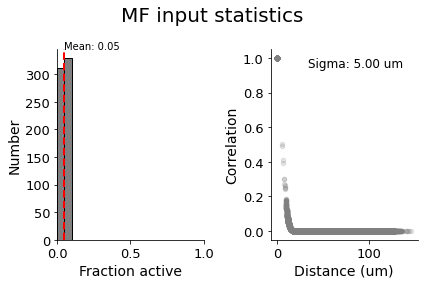


Mean:  0.14987499999999998


<Figure size 432x288 with 0 Axes>

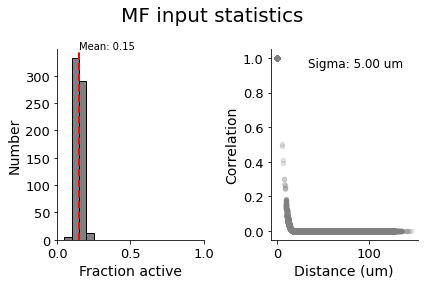


Mean:  0.24922395833333333


<Figure size 432x288 with 0 Axes>

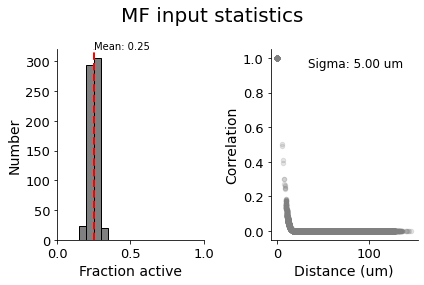


Mean:  0.35125


<Figure size 432x288 with 0 Axes>

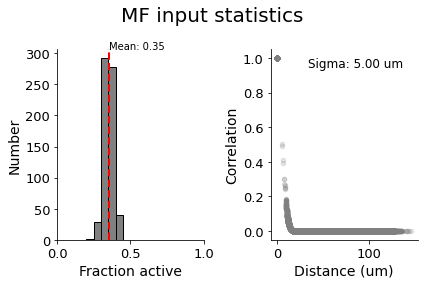


Mean:  0.45332812499999997


<Figure size 432x288 with 0 Axes>

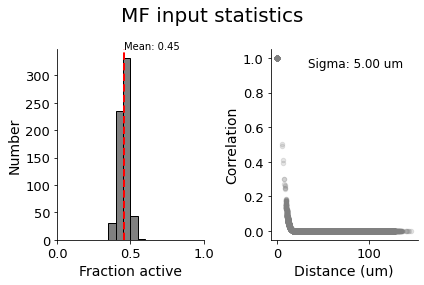


Mean:  0.5492604166666666


<Figure size 432x288 with 0 Axes>

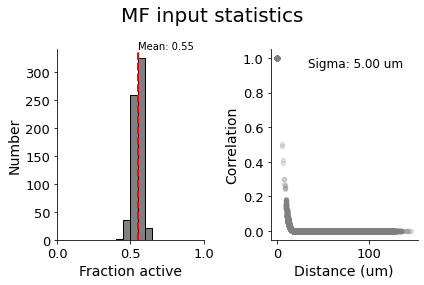


Mean:  0.6500520833333333


<Figure size 432x288 with 0 Axes>

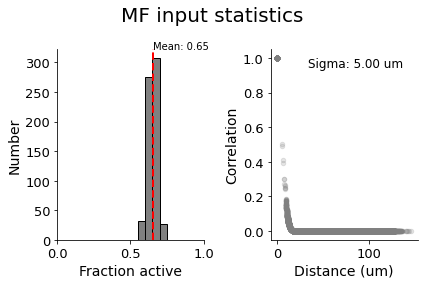


Mean:  0.7491354166666667


<Figure size 432x288 with 0 Axes>

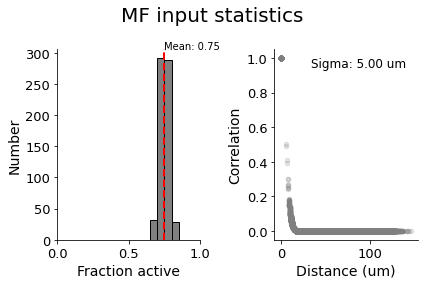


Mean:  0.8499479166666667


<Figure size 432x288 with 0 Axes>

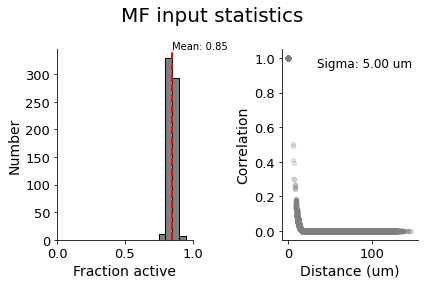


Mean:  0.9500677083333333


<Figure size 432x288 with 0 Axes>

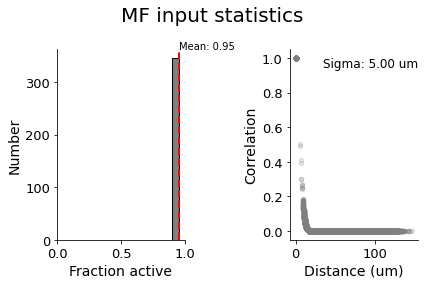

In [14]:

## For each of the chosen sigmas
for sigma in sigmas: 
    
    ## Generating Lambda and Gamma for the dichotomized gaussian model 

    print('Sigma: ' + str(sigma))
    
    ## Scaling
    scale = norm.pdf(0,0,sigma)/0.9

    ## Calculating correlations between MFs
    dists = np.zeros((len(glos), len(glos)))
    rho_specified = np.zeros((len(glos), len(glos)))
    
    k = 0
    for ind1,i in enumerate(range(glos.shape[0])):

        l = k + 1
        for j in list(range(glos.shape[0]))[ind1+1:]:                       

            dists[k][l] = math.dist(glos[i], glos[j])
            rho_specified[k][l] = norm.pdf(dists[k][l],0,sigma)/scale
            rho_specified[l][k] = rho_specified[k][l]
            dists[l][k] = dists[k][l]
            l +=1

        rho_specified[k][k] = 1.0

        k += 1

    
    # Generating Lambda and Gamma
    Rs = np.zeros((len(glos), len(glos), len(f_mf)))
    gs = np.zeros(len(f_mf))

    h = Higham()

    for k in range(len(f_mf)):

        print('f_mf: ' + str(f_mf[k]))
        ## Getting specified covariance 
        cov_specified = rho_specified*(f_mf[k] - f_mf[k]**2)

        if sum(linalg.eig(cov_specified)[0] < 0) > 0:
            print('not positive definite!')

        g, R = findLatentGaussian(f_mf[k]*np.ones(len(glos)), cov_specified) 
        ## Applying higham correction
        R = h.higham_correction(R)
        
        ## Saving data
        Rs[:,:,k] = R
        gs[k] = g[0];

        ## Checking that all elements of g are the same
        ## (because all MFs have same mean)

        if abs(sum(g) - g[0]*len(glos)) > np.sqrt(eps):
            print('g should be homogeneous')
    
    
    ## Generating directory to store inputs
    DATA_DIR = '../data/input_patterns'
    SEED_DATA_DIR = os.path.join(DATA_DIR, 'seed' + str(seed))
    os.makedirs(SEED_DATA_DIR, exist_ok = True)
    sys.path.insert(1, SEED_DATA_DIR)
                 
    # Saving g and R matrix
    with open(SEED_DATA_DIR + '/mf_patterns_r' + str(sigma) + '.npy', 'wb') as f:
        np.save(f, Rs)
        np.save(f, gs)

    ## Generating input patterns using Lambda and Gamma 
    for k in range(len(f_mf)):

        R = Rs[:,:,k]
        g = gs[k]*np.ones(len(glos)).reshape(1, len(glos))

        # Generating samples from a multivariate Gaussian
        z = mvn(mean=np.zeros(len(glos)),
                    cov=R, allow_singular=True
                    ).rvs(size=[num_patterns, len(g)])  
        z = z.reshape(num_patterns, -1, len(glos))
        z = z + g
        x_mf = heaviside(z.transpose(1, 0, 2))

        elem = f_mf[k]

        ## Saving input patterns 
        with open(SEED_DATA_DIR + '/mf_activity_f_mf_' + str(elem) + '_s_' + str(sigma) + '.npy', 'wb') as f:
                np.save(f, x_mf)

        fraction_patterns = np.zeros(num_patterns)
        for i in range(x_mf.shape[1]):
            fraction_patterns[i] = x_mf[:,i].mean()
        
        print("")
        print('Mean: ', fraction_patterns.mean())

        


        plt.subplots_adjust(hspace=0.5)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6,4))
        plt.rcParams["savefig.facecolor"] = "white"
        fig.suptitle('MF input statistics', fontsize = 20)
        size = 14
        ax1.hist(fraction_patterns, bins = np.arange(0, 1, 0.05), ec='black', color = 'gray')
        ax1.set_ylabel('Number', fontsize = size)
        ax1.set_xlabel('Fraction active', fontsize = size)
        ax1.axvline(fraction_patterns.mean(), color='r', linestyle='dashed', linewidth=2)
        min_ylim, max_ylim = ax1.set_ylim()
        ax1.text(fraction_patterns.mean()*1.0, max_ylim*1.0, 'Mean: {:.2f}'.format(fraction_patterns.mean()))
        ax1.tick_params(axis='both', which='major', labelsize=13)
        
        # Hide the right and top spines
        ax1.spines.right.set_visible(False)
        ax1.spines.top.set_visible(False)
        
        # Only show ticks on the left and bottom spines
        ax1.yaxis.set_ticks_position('left')
        ax1.xaxis.set_ticks_position('bottom')
        ax1.set_xlim([0.0, 1.0])

        ax2.scatter(dists, rho_specified, alpha = 0.1, s = 20, color = 'gray')
        ax2.set_ylabel('Correlation', fontsize = size)
        ax2.set_xlabel('Distance (um)', fontsize = size)
        min_ylim, max_ylim = ax2.set_ylim()
        ax2.text(dists.mean() - 30, max_ylim*0.9,'Sigma: {:.2f} um'.format(sigma), fontsize = 12)
        ax2.tick_params(axis='both', which='major', labelsize=13)
        
        # Hide the right and top spines
        ax2.spines.right.set_visible(False)
        ax2.spines.top.set_visible(False)
        
        # Only show ticks on the left and bottom spines
        ax2.yaxis.set_ticks_position('left')
        ax2.xaxis.set_ticks_position('bottom')

        fig.tight_layout() 
        
        ## Generating directory to store the visualizations for the inputs statistics 
        RESULTS_DIR = '../results/inputs_statistics_visualization'
        SEED_RESULTS_DIR = os.path.join(RESULTS_DIR, 'seed' + str(seed))
        SIGMA_RESULTS_DIR = os.path.join(SEED_RESULTS_DIR, 'sigma_' + str(sigma))
        os.makedirs(SIGMA_RESULTS_DIR, exist_ok = True)
        
        sys.path.insert(1, SIGMA_RESULTS_DIR)

        plt.savefig(SIGMA_RESULTS_DIR + '/fraction_' + str(elem) + '.png', bbox_inches='tight')
        plt.show()

        